In [179]:
import numpy as np
import pandas as pd
import os
import yfinance as yf

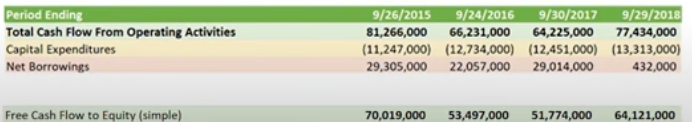

In [180]:
b = yf.Ticker("AAPL").balance_sheet
b

,2021-09-25,2020-09-26,2019-09-28,2018-09-29
Total Liab,2.879120e+11,2.585490e+11,2.480280e+11,2.585780e+11
Total Stockholder Equity,6.309000e+10,6.533900e+10,9.048800e+10,1.071470e+11
Other Current Liab,5.357700e+10,4.786700e+10,4.324200e+10,3.929300e+10
Total Assets,3.510020e+11,3.238880e+11,3.385160e+11,3.657250e+11
Common Stock,5.736500e+10,5.077900e+10,4.517400e+10,4.020100e+10
Other Current Assets,1.411100e+10,1.126400e+10,1.235200e+10,1.208700e+10
Retained Earnings,5.562000e+09,1.496600e+10,4.589800e+10,7.040000e+10
Other Liab,4.305000e+10,4.610800e+10,5.050300e+10,4.891400e+10
Treasury Stock,1.630000e+08,-4.060000e+08,-5.840000e+08,-3.454000e+09
Other Assets,3.876200e+10,3.395200e+10,3.297800e+10,2.228300e+10


In [181]:
b.columns

DatetimeIndex(['2021-09-25', '2020-09-26', '2019-09-28', '2018-09-29'], dtype='datetime64[ns]', name='', freq=None)

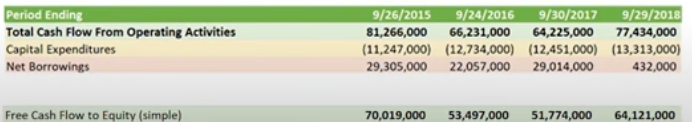

In [182]:
c = yf.Ticker("AAPL").cashflow
c = c[c.columns[::-1]]
c.columns = pd.DatetimeIndex(c.columns).year
c

,2018,2019,2020,2021
Investments,3.084500e+10,5.809300e+10,5.335000e+09,-2.819000e+09
Change To Liabilities,9.172000e+09,-2.548000e+09,-1.981000e+09,1.400200e+10
Total Cashflows From Investing Activities,1.606600e+10,4.589600e+10,-4.289000e+09,-1.454500e+10
Net Borrowings,4.320000e+08,-7.819000e+09,2.499000e+09,1.266500e+10
Total Cash From Financing Activities,-8.787600e+10,-9.097600e+10,-8.682000e+10,-9.335300e+10
Change To Operating Activities,3.001600e+10,-8.960000e+08,8.810000e+08,-6.146000e+09
Issuance Of Stock,6.690000e+08,7.810000e+08,8.800000e+08,1.105000e+09
Net Income,5.953100e+10,5.525600e+10,5.741100e+10,9.468000e+10
Change In Cash,5.624000e+09,2.431100e+10,-1.043500e+10,-3.860000e+09
Repurchase Of Stock,-7.526500e+10,-6.971400e+10,-7.599200e+10,-9.252700e+10


In [183]:
CPO = c.loc["Total Cash From Operating Activities"].to_frame().T
CPO

,2018,2019,2020,2021
Total Cash From Operating Activities,7.743400e+10,6.939100e+10,8.067400e+10,1.040380e+11


In [184]:
CAPEX = c.loc["Capital Expenditures"].to_frame().T
CAPEX

,2018,2019,2020,2021
Capital Expenditures,-1.331300e+10,-1.049500e+10,-7.309000e+09,-1.108500e+10


In [185]:
FCF = (CPO.iloc[0] + CAPEX.iloc[0]).to_frame().T
FCF

,2018,2019,2020,2021
0,6.412100e+10,5.889600e+10,7.336500e+10,9.295300e+10


In [186]:
net_income = c.loc["Net Income"].to_frame().T
net_income

,2018,2019,2020,2021
Net Income,5.953100e+10,5.525600e+10,5.741100e+10,9.468000e+10


In [187]:
FFCE_net_income = round((FCF.iloc[0] / net_income.iloc[0]) * 100).to_frame().T
FFCE_net_income

,2018,2019,2020,2021
0,108.0,107.0,128.0,98.0


In [188]:
f = yf.Ticker("AAPL").financials
f = f[f.columns[::-1]]
f.columns = pd.DatetimeIndex(f.columns).year
f

,2018,2019,2020,2021
Research Development,1.4236e+10,1.6217e+10,1.8752e+10,2.1914e+10
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,7.2903e+10,6.5737e+10,6.7091e+10,1.09207e+11
Minority Interest,None,None,None,None
Net Income,5.9531e+10,5.5256e+10,5.7411e+10,9.468e+10
Selling General Administrative,1.6705e+10,1.8245e+10,1.9916e+10,2.1973e+10
Gross Profit,1.01839e+11,9.8392e+10,1.04956e+11,1.52836e+11
Ebit,7.0898e+10,6.393e+10,6.6288e+10,1.08949e+11
Operating Income,7.0898e+10,6.393e+10,6.6288e+10,1.08949e+11
Other Operating Expenses,None,None,None,None


In [189]:
total_revenue = f.loc["Total Revenue"].to_frame().T
total_revenue

,2018,2019,2020,2021
Total Revenue,2.65595e+11,2.60174e+11,2.74515e+11,3.65817e+11


In [190]:
growths = []
for year1, year2 in zip(total_revenue, total_revenue.iloc[:, 1:]):
    y1 = total_revenue[year1].iloc[0]
    y2 = total_revenue[year2].iloc[0]
    print(y1, y2)
    growth = round((y2 - y1)/y1*100, 2)
    growths.append(growth)
    print(year2, growth)

265595000000.0 260174000000.0
2019 -2.04
260174000000.0 274515000000.0
2020 5.51
274515000000.0 365817000000.0
2021 33.26


In [191]:
a = yf.Ticker("AAPL").analysis["Growth"].to_frame().T
growths.append(a["0Y"].iloc[0]*100)
growths.append(a["+1Y"].iloc[0]*100)
growths

[-2.04, 5.51, 33.26, 9.4, 6.800000000000001]

In [192]:
median_growth = round(np.median(growths),2 )
median_growth

6.8

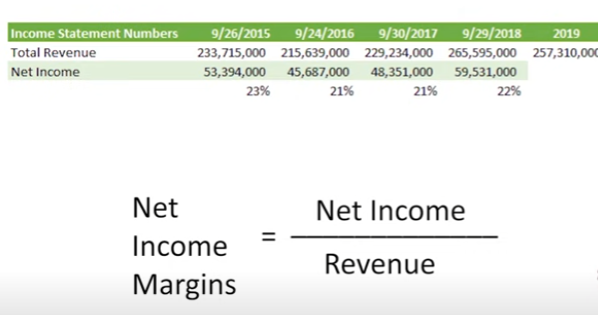

In [193]:
net_income_margins = pd.concat([total_revenue, net_income])
net_income_margins

,2018,2019,2020,2021
Total Revenue,2.65595e+11,2.60174e+11,2.74515e+11,3.65817e+11
Net Income,5.9531e+10,5.5256e+10,5.7411e+10,9.468e+10


In [ ]:
for 

In [ ]:
import datetime
current_year = datetime.datetime.now().year
years_forward = 3

for y in range(current_year, current_year+years_forward):
    total_revenue[y] = total_revenue[y-1] * (1+ (median_growth/ 100))
    
total_revenue